## **프로젝트: 고양이 수염 스티커 만들기**

### **Step 1. 스티커 구하기 or 만들기**

In [1]:
# 필요한 패키지 import 하기
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

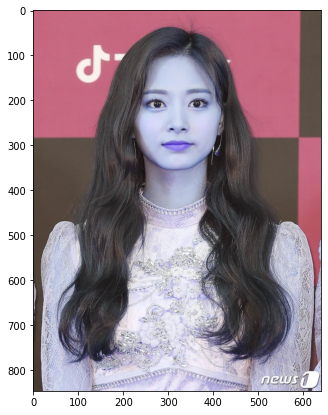

In [2]:
my_image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/쯔위.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 출력용 이미지 복사

plt.figure(figsize=(7, 7))
plt.imshow(img_bgr)
plt.show()

OpenCv는 BGR(파랑, 녹색, 빨강)을 사용해서 색상이 바뀌어 출력이 되는 것을 확인할 수 있다.

색깔 보정처리를 해주자!

In [3]:
plt.figure(figsize=(7, 7))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### **Step 2. 얼굴 검출 & 랜드마크 검출 하기**

In [4]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) # (image, num of image pyramid)
print(dlib_rects) # 찾은 얼굴 영역 박스 리스트

rectangles[[(221, 160) (407, 345)]]


찾은 얼굴을 화면에 출력해보도록 하자.

In [5]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### **Step 3. 스티커 적용 위치 확인하기**

In [6]:
# 저장한 landmark 모델 불러오기
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
# landmark 찾아내기
list_landmarks = [] # 랜드마크의 위치를 저장할 list 생성

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 랜드마크 수 확인

68


In [8]:
# landmark 사진에 출력하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### **Step 4. 스티커 적용하기**

직접 해본 결과, 인중과 코의 중간 위치로 수염을 배치하는 것이 적절하다고 판단되어 위치를 아래와 같이 조정해주었다.

In [9]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # 코의 index는 30
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = (landmark[30][1] + landmark[33][1]) // 2 # 이미지에서 코 부위의 y값 + 인중의 y값 // 2
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({w},{h})')

(322, 254)
(x,y) : (322,263)
(w,h) : (187,187)


(187, 187, 3)


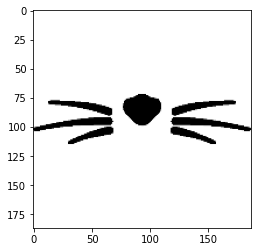

In [10]:
# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
print(img_sticker.shape)

In [11]:
# 스티커 이미지 좌표
refined_x = x - w // 2
refined_y = y - h // 2
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (229,170)


다행히도 스티커가 이미지의 영역을 벗어나지 않는다. 

만약 스티커가 이미지의 영역을 벗어날 경우를 대비하여 원본 이미지의 범위를 벗어난 스티커 부분을 제거하는 코드를 추가해주기로 했다.

In [12]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0
print(f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (229,170)


In [13]:
# 스티커 적용하기
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 bounding box와 landmark를 제거하고 최종 결과만 출력해보자.

In [14]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8), 0.5, 0)

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off') # 축 제거
plt.show()

스티커를 투명하게 적용함으로써 원본 이미지가 스티커 뒤로 잘 보이고, 원하는 위치에 스티커가 정확하게 출력된 것을 확인할 수 있다.

### **Step 5. 문제점 찾아보기**

이미지에 스티커를 적용하는 함수를 만들어 다양한 각도에서 촬영된 이미지에 적용해보자.

In [15]:
def apply_cat_sticker(image_path):
    # 이미지 파일 읽기
    img_bgr = cv2.imread(image_path)
    img_show = img_bgr.copy()

    # detector 선언
    detector_hog = dlib.get_frontal_face_detector()

    # bounding box 추출
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)

    # landmark 모델 불러오기
    landmark_predictor = dlib.shape_predictor(model_path)

    # bounding box 추가된 이미지
    img_with_box = img_bgr.copy()
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        cv2.rectangle(img_with_box, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

    # bounding box와 landmark가 포함된 이미지
    img_with_landmarks = img_bgr.copy()
    
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom() 
        cv2.rectangle(img_with_landmarks, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

        # landmark 찾기
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))

        # landmark 출력
        for point in list_points:
            cv2.circle(img_with_landmarks, point, 2, (0, 255, 255), -1)

    # bounding box와 landmark가 제거된 이미지에 고양이 수염 추가
    img_bgr_cat = img_bgr.copy()
    
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))

        x = list_points[30][0] 
        y = (list_points[30][1] + list_points[33][1]) // 2
        w = dlib_rect.width()
        h = dlib_rect.height()

        # 스티커 이미지 읽기
        img_sticker = cv2.imread(sticker_path)
        img_sticker = cv2.resize(img_sticker, (w, h))

        # 스티커 적용하기
        refined_x = x - w // 2
        refined_y = y - h // 2

        if refined_x < 0:
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0
        
        sticker_area = img_bgr_cat[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
        img_bgr_cat[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
            cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8), 0.5, 0)
    
    # 이미지 출력
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Box')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(cv2.cvtColor(img_with_landmarks, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Box and Landmarks')
    plt.axis('off')

    plt.subplot(224)
    plt.imshow(cv2.cvtColor(img_bgr_cat, cv2.COLOR_BGR2RGB))
    plt.title('Image with Cat Sticker')
    plt.axis('off')

    plt.show()

#### **측면 사진**

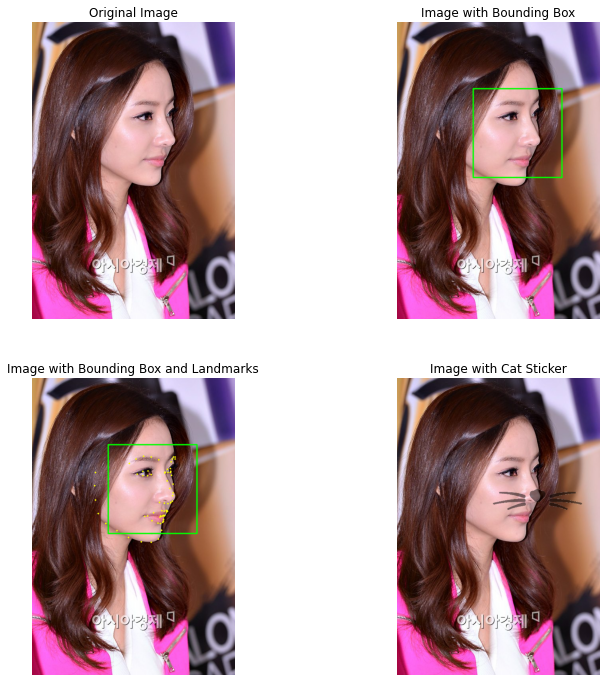

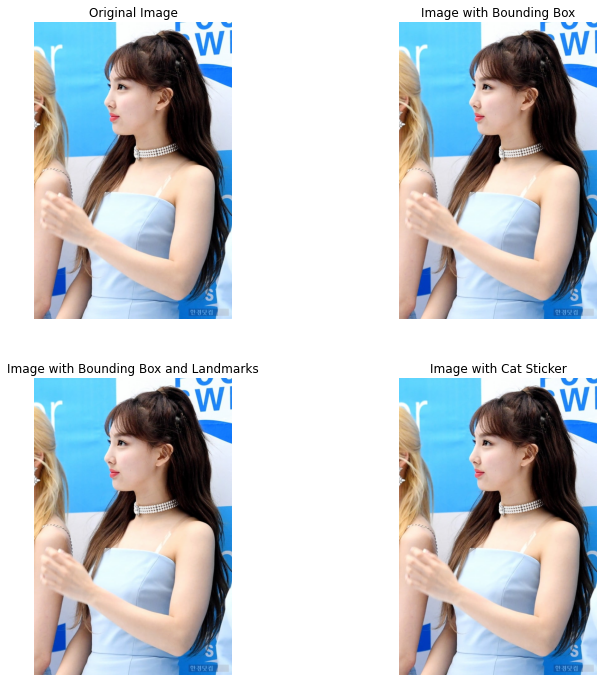

In [16]:
# 이미지 경로
image_paths = [
    os.getenv('HOME') + '/aiffel/camera_sticker/images/미나.jpg',
    os.getenv('HOME') + '/aiffel/camera_sticker/images/한채영.jpg',
    os.getenv('HOME') + '/aiffel/camera_sticker/images/나연.jpg'
]

# 이미지들에 스티커 적용 및 출력
for image_path in image_paths:
    apply_cat_sticker(image_path)

측면에서 찍힌 사진을 분석한 결과, 첫번째와 두번째 사진에서는 얼굴 인식과 랜드마크 인식이 정확하게 이루어진 것을 확인할 수 있다.  
세번째 사진에서는 바운딩 박스가 그려지지 않았으며, 한쪽 눈이 보이지 않아서 얼굴 인식이 실패한 것으로 보인다.

#### **옆으로 누워져 있는 사진**

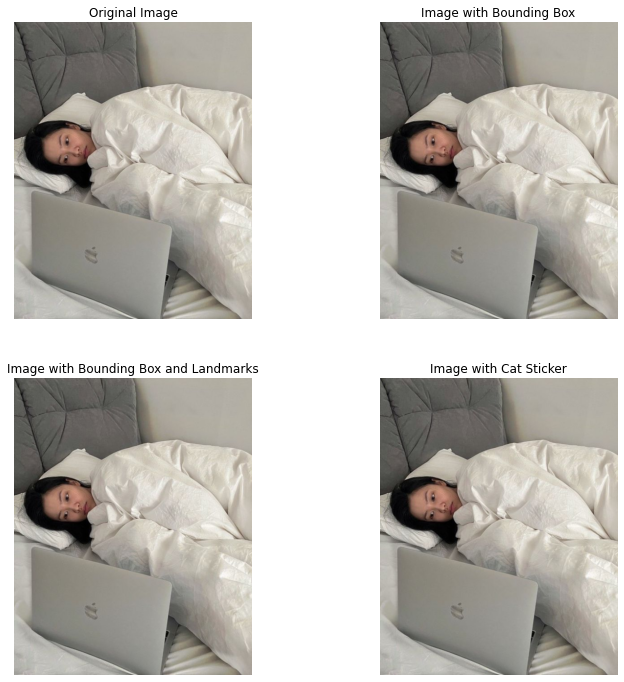

In [17]:
# 이미지 경로
image_paths = [
    os.getenv('HOME') + '/aiffel/camera_sticker/images/조이.jpeg',
    os.getenv('HOME') + '/aiffel/camera_sticker/images/예리.jpg',
    os.getenv('HOME') + '/aiffel/camera_sticker/images/화사.jpg'
]

# 이미지들에 스티커 적용 및 출력
for image_path in image_paths:
    apply_cat_sticker(image_path)

옆으로 누워져 있는 사진에서는 얼굴 인식 알고리즘은 정면에서 촬영된 얼굴을 기준으로 동작하므로, 제대로 작동하지 않은 것 같다.  
이는 측면에서는 눈, 코, 입 등의 얼굴 특징이 다르게 보이기 때문에 얼굴 인식이 어려워지는 것으로 추측된다. 

#### **눈을 감은 사진**

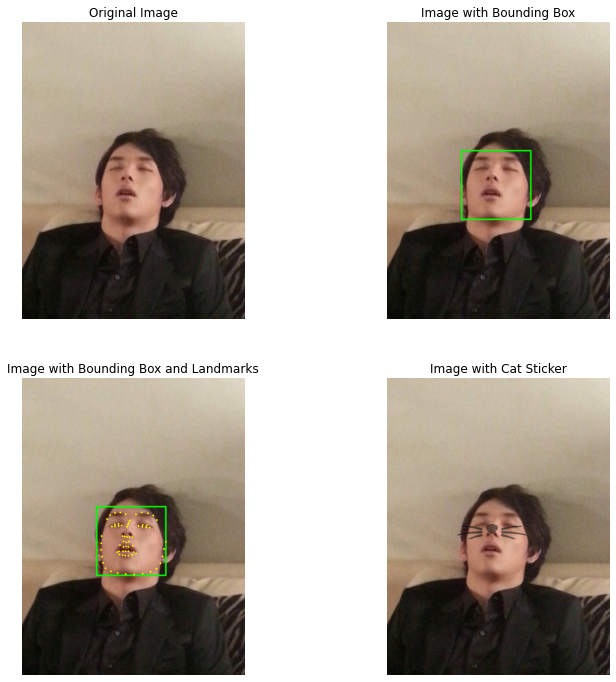

In [18]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/임시완.jpg'

# 스티커 적용
apply_cat_sticker(image_path)

#### **안경 쓴 사진**

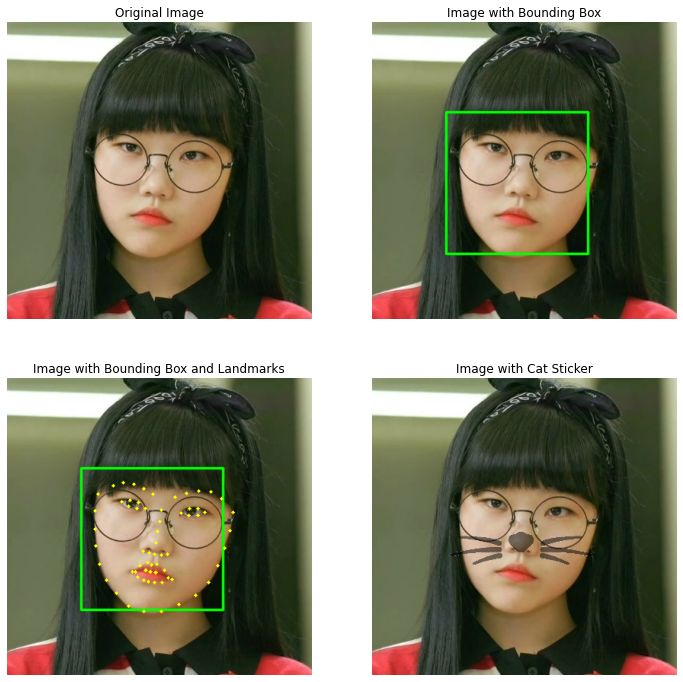

In [19]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/이수현.jpeg'

# 스티커 적용
apply_cat_sticker(image_path)

#### **마스크 쓴 사진**

In [20]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/마스크.jpg'

# 스티커 적용
apply_cat_sticker(image_path)

눈을 감거나 안경이나 마스크를 쓴 사진에서도 얼굴을 인식하는 것을 확인할 수 있다.  
하지만 마스크를 쓴 사진에서는 고양이 수염의 위치가 조금 위로 올라간 모습이 보인다.  
마스크로 인해 얼굴의 일부 특징이 가려지기 때문에 랜드마크 위치가 정확하게 감지되지 않은 것 같다.

#### **멀리 있는 사진**

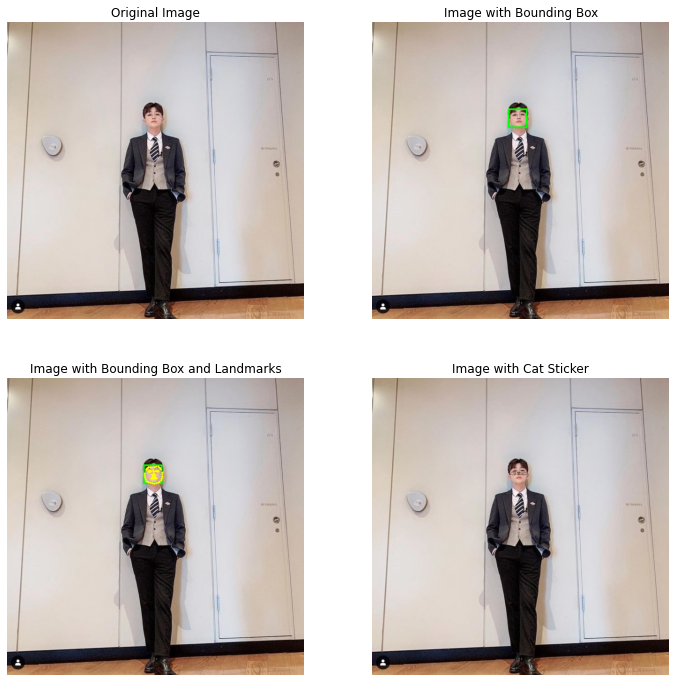

In [21]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/딘딘.jpg'

# 스티커 적용
apply_cat_sticker(image_path)

#### **밝기가 어두운 사진**

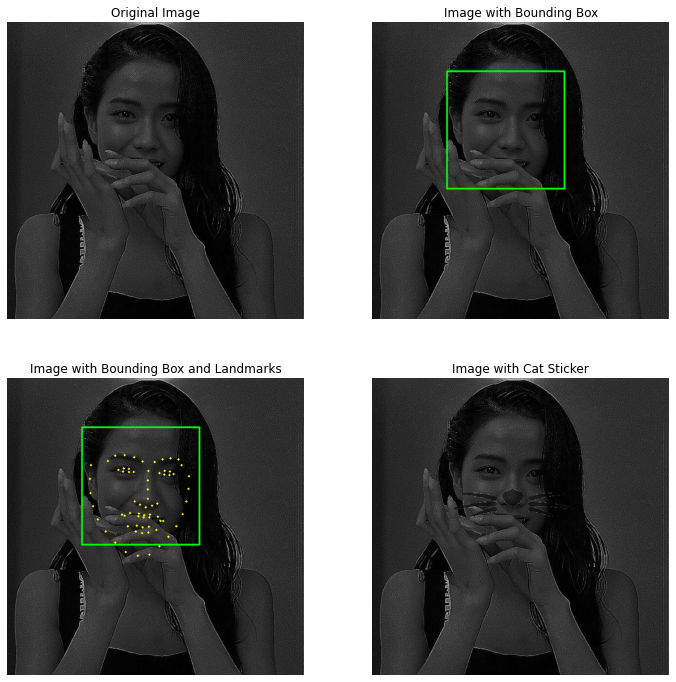

In [22]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/지수.jpg'

# 스티커 적용
apply_cat_sticker(image_path)

멀리서 찍힌 사진이나 어두운 사진에서도 얼굴 인식, 랜드마크 인식, 그리고 고양이 수염 입히기까지 잘 작동하는 것을 확인할 수 있다.

#### **단체 사진**

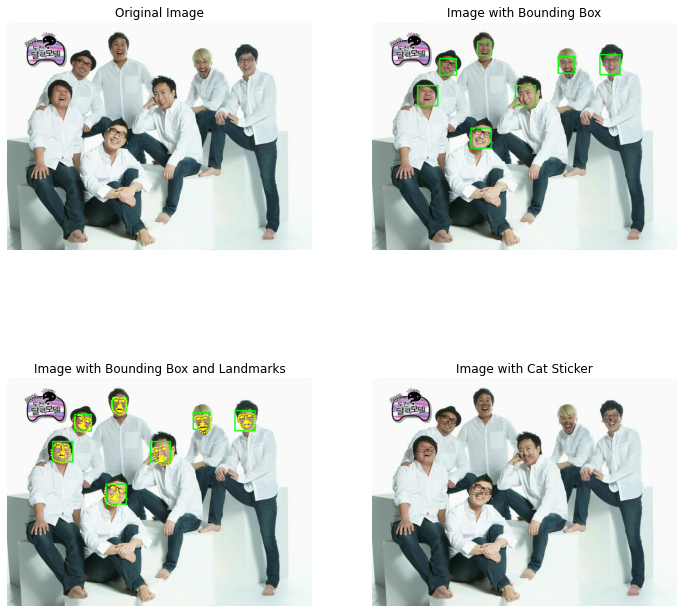

In [23]:
# 이미지 경로
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/무한도전.jpg'

# 스티커 적용
apply_cat_sticker(image_path)

처음에는 단체사진에서 여러 얼굴이 포함된 경우에는 한명에게만 고양이 수염이 적용되는 문제가 발생하였다.  
이 문제를 해결하기 위해 위의 코드를 수정하여 모든 얼굴에 고양이 수염을 적용할 수 있도록 변경하였다.

---

### **프로젝트 회고**

#### **생각해볼 수 있는 문제점**
**얼굴 각도에 따라 스티커가 어떻게 변해야할까요?**  
얼굴 각도에 따라 스티커의 방향과 위치 또한 조정되어야 한다.  

**멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?**  
멀리서 촬영하거나 옆으로 누워서 촬영하면 얼굴이 작게 나와 검출이 어려울 수 있다.

**실행 속도가 중요할까요?**  
실행 속도가 느리면 사용자들이 불편함을 느낄 수 있으며, 결과적으로 사용성과 만족도를 저하시킬 수 있다. 따라서 실행 속도는 매우 중요한 요소라고 생각한다.

**스티커앱을 만들 때 정확도가 얼마나 중요할까요?**  
실행 속도와 마찬가지로 굉장히 중요하다고 생각한다. 애초에 해당 어플의 목적은 스티커를 올바른 위치에 정확하게 적용하는 것인데 만약 정확도가 부족하다면 스티커가 얼굴이 아닌 곳에 적용되거나 부자연스럽게 적용되는 상황이 발생할 수 있어 해당 어플에 대한 신뢰성이 떨어질 것이다. 따라서 이와 같은 어플을 개발할 때는 정확도를 최우선으로 고려하여 정확한 얼굴 인식과 스티커 적용이 가능하도록 해야 한다.

#### **새로 알게 된 것!**
* Landmark: 눈, 코, 입, 귀와 같은 얼굴의 특정 부위의 위치를 찾아내는 기술
* Keypoint Detection: 이미지나 비디오에서 특정한 객체나 구조물의 중요한 지점을 자동으로 찾아내는 작업
* OpenCV: 컴퓨터 비전 및 이미지 처리를 위한 오픈 소스 라이브러리 (BGR 사용)
* Sliding Window: 작은 사각형 또는 윈도우를 이미지 위에 이동시키면서 해당 영역에 특정한 패턴이나 개체가 존재하는지 확인하는 방식
* Upsampling: 이미지의 크기를 확대하는 작업
* Image Pyramid: 이미지의 다양한 해상도 버전을 생성하는 기술

**cv2.imread(fileName, flag)**  
이미지 파일을 읽어들일 때 사용하는 함수로 3가지 flag가 있다.
* cv2.IMREAD_COLOR: 이미지 파일을 컬러로 읽어들이며 정수 값 1을 가지고 있다.
* cv2.IMREAD_GRAYSCALE: 이미지 파일을 그레이스케일로 읽어들이며 정수 값 0을 가지고 있다.
* cv2.IMREAD_UNCHANGED: 이미지 파일을 알파 채널까지 포함하여 읽어들이며 정수 값 -1을 가지고 있다.

**Object Keypoint Estimation**  
객체 내부의 점을 찾는 기술로, 알고리즘은 크게 2가지로 나누어진다.
* top-down: bounding box를 찾고 box 내부의 keypoint를 예측
* bottom-up: 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화해서 box 생성

**랜드마크를 표시할 때 노란색 점의 굵기가 사진마다 다른 이유는?**
1. 이미지 해상도: 해상도가 높을수록 더 많은 픽셀이 있으므로 노란색 점이 더 많은 픽셀에 표현될 수 있다. 따라서 해상도가 높은 사진에서는 노란색 점의 굵기가 상대적으로 더 작아질 수 있다.

2. 객체 크기: 작은 객체에서는 랜드마크 점의 크기가 상대적으로 더 크게 보일 수 있으며, 큰 객체에서는 랜드마크 점의 크기가 상대적으로 작게 보일 수 있다.

3. 표시 방식: OpenCV 또는 다른 이미지 처리 라이브러리에서는 점의 크기를 픽셀 단위로 설정할 수 있다. 따라서 랜드마크 점의 굵기를 설정하는 방식에 따라 사진마다 굵기가 달라질 수 있다.

**참고한 레퍼런스**
<br>OpenCV : 이미지 다루기 https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html
<br>Image Pyramids https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html
<br>dlib.rectangles http://dlib.net/python/index.html#dlib.rectangles
<br>AFLW dataset https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/
<br>One Millisecond Face Alignment with an Ensemble of Regression Trees https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf
<br>고양이 수염 이미지 https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1
<br>[OpenCV] 이미지 회전(중앙 기준 회전) cv2.getRotationMatrix2D - 얼굴 회전 각도 구하기 https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0